In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.odr import *
from scipy import linalg
from scipy import stats
from scipy import optimize
from celluloid import Camera
import time
from tqdm.notebook import tqdm
import threading
# from multiprocessing import Pool
import multiprocessing
All = pd.read_csv(r'/home/jin/바탕화면/data WD/all.txt',delim_whitespace=True,header=0)
#r'C:/home/jin/바탕화면/data WD/all.txt'

plt.rcParams['font.size'] = '16'
T,R,M,Rerr, Merr,Terr = All['Teff'].to_numpy(),All['Radius'].to_numpy() ,All['Mass'].to_numpy() ,All['Rerr'].to_numpy() ,All['Merr'].to_numpy(),All['Terr'].to_numpy()
Object = All['Object'].to_numpy()
#All
Ts = 5778
logR_err = np.log10(1+Rerr/R)
logM_err =np.log10(1+Merr/M)
log_R =np.log10(R)
log_M = np.log10(M)
log_T = np.log10(T)
logT_err = np.log10(1+Terr/T)

35.09초 만에 작업이 완료되었습니다.
0.03439608177096904


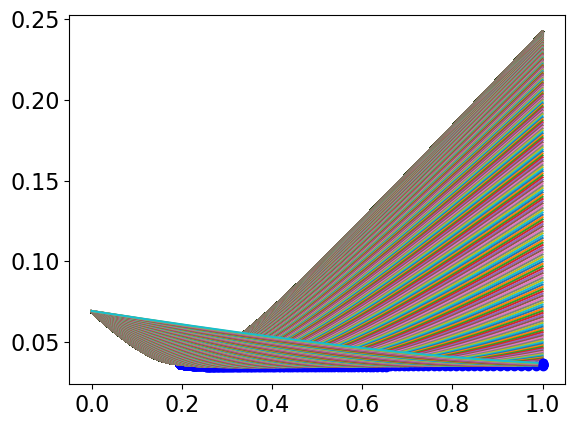

In [32]:
fig = plt.figure()

def test():
    x = np.row_stack((log_M,T))
    N = 1000
    TT = np.logspace(-5,5,N)
    c_T_all_Model3 = np.zeros(N)
    cc = np.linspace(0,1,N)
    b_M_all_Model3 = np.zeros(N)
    resM3 = np.zeros((N,N))
    a_all_Model3 = np.zeros(N)
    resM3_Min = np.zeros(N)
    beta3 = np.zeros(N)
    for ii, t0 in enumerate(TT):
        def linfit(beta,x):
            return beta[0] + beta[1]*x[0] + beta[2]*np.log10(1+x[1]/t0)
        linmod = Model(linfit)
        data = RealData(x,log_R)
        odr = ODR(data,linmod,beta0=[1.,1.,1.])
        out=odr.run()
        a_all_Model3[ii],b_M_all_Model3[ii],c_T_all_Model3[ii] = out.beta
        for jj, beta in enumerate(cc):
            R_test = np.log10(R/(1+T/t0)**(beta))
            resM3[ii,jj] = np.std(R_test -b_M_all_Model3[ii]*log_M)
        plt.plot(cc,resM3[ii,:])
        bb = resM3[ii,:].argmin()
        plt.plot(cc[bb],resM3[ii,bb],'bo')
        resM3_Min[ii] = resM3[ii,bb]
        beta3[ii] = cc[bb] 
    tt = np.unravel_index(resM3.argmin(),resM3.shape)
    qq , beta0 = tt
    return resM3[qq,beta0] , cc[beta0] , c_T_all_Model3[qq] ,b_M_all_Model3[qq] ,TT[qq] ,a_all_Model3[qq]




if __name__ == '__main__':
 
    start = time.perf_counter()
 
    processes = []
    for _ in range(4):
        p = multiprocessing.Process(target=test) ## 각 프로세스에 작업을 등록
        p.start()
        processes.append(p)
 
    for process in processes:
        process.join()
    finish = time.perf_counter()
    print(f'{round(finish-start,2)}초 만에 작업이 완료되었습니다.')
    
print(test()[0])

In [ ]:
fig = plt.figure()
iteration = 5

alpha_m3 =np.zeros(iteration)
beta_m3 = np.zeros(iteration)
t_m3= np.zeros(iteration)
res_mm3 = np.zeros(iteration)
R_m3 = np.zeros(iteration)

alpha_m4 =np.zeros(iteration)
beta_m4 = np.zeros(iteration)
t_m4= np.zeros(iteration)
res_mm4 = np.zeros(iteration)
R_m4= np.zeros(iteration)

for pp in tqdm(range(iteration)):
    new_M = np.zeros(len(Merr))
    new_R = np.zeros(len(Rerr))
    for i, dM in enumerate(Merr):
        delM = stats.norm.rvs(loc=0,scale=dM)
        if (delM+ M[i])<= 0 :
            delM = 0.5* delM
        new_M[i] = M[i]+ delM
    for i, dR in enumerate(Rerr):
        delR = stats.norm.rvs(loc=0,scale=dR)
        if (delR+ R[i])<= 0 :
            delR = 0.5* delR        
        new_R[i] = R[i]+ delR

    def test_two():
        log_M = np.log10(new_M)
        log_R = np.log10(new_R)
        x = np.row_stack((log_M,T))
        N = 1000


        TT = np.logspace(-5,5,N)
        cc = np.linspace(0,1,N)
        a_all_Model3 = np.zeros(N)
        c_T_all_Model3 = np.zeros(N)
        b_M_all_Model3 = np.zeros(N)
        resM3 = np.zeros((N,N))
        beta3 = np.zeros(N)

        c_T_all_Model4 = np.zeros(N)
        b_M_all_Model4 = np.zeros(N)
        a_all_Model4 = np.zeros(N)
        resM4 = np.zeros((N,N))
        beta4 = np.zeros(N)
        for ii, t0 in tqdm(enumerate(TT)):
            def linfit_Model3(beta,x):
                return beta[0] + beta[1]*x[0] + beta[2]*np.log10(1+x[1]/t0)
            def linfit_Model4(beta,x):
                return beta[0] + beta[1]*x[0] + np.log10(1+(x[1]/t0)**beta[2])
            data = RealData(x,log_R)  
            linmod_Model3 = Model(linfit_Model3)
            linmod_Model4 = Model(linfit_Model4)  
            odr_model3 = ODR(data,linmod_Model3,beta0=[1.,1.,1.])
            odr_model4 = ODR(data,linmod_Model4,beta0=[1.,1.,1.])  
            out_model3=odr_model3.run()
            out_model4=odr_model4.run()
            a_all_Model3[ii],b_M_all_Model3[ii],c_T_all_Model3[ii] = out_model3.beta
            a_all_Model4[ii],b_M_all_Model4[ii],c_T_all_Model4[ii] = out_model4.beta
            for jj, beta in enumerate(cc):
                R_test_Model3 = np.log10(new_R/(1+T/t0)**(beta))
                R_test_Model4 = np.log10(new_R/(1+(T/t0)**(beta)))
                resM3[ii,jj] = np.std(R_test_Model3 -b_M_all_Model3[ii]*log_M)
                resM4[ii,jj] = np.std(R_test_Model4-b_M_all_Model4[ii]*log_M)
            mm3 = resM3[ii,:].argmin()
            beta3[ii] = cc[mm3]

            mm4 = resM4[ii,:].argmin()
            beta4[ii] = cc[mm4]
        return resM3 , resM4 , beta3 , beta4 , a_all_Model3 , a_all_Model4 , b_M_all_Model3 , b_M_all_Model4 , TT, cc

    if __name__ == '__main__':
        start = time.perf_counter()

        processes = []
        for _ in range(4):
            p = multiprocessing.Process(target=test_two) ## 각 프로세스에 작업을 등록
            p.start()
            processes.append(p)

        for process in processes:
            process.join()
            finish = time.perf_counter()
            print(f'{round(finish-start,2)}초 만에 작업이 완료되었습니다.')

    resM3 , resM4 , beta3 , beta4 , a_all_Model3 , a_all_Model4 , b_M_all_Model3 , b_M_all_Model4 , TT, cc = test_two() 

    tt_m3 = np.unravel_index(resM3.argmin(),resM3.shape)
    qq , beta0_m3 = tt_m3

    tt_m4 = np.unravel_index(resM4.argmin(),resM4.shape)
    kk , beta0_m4= tt_m4

    R_m3[pp] = a_all_Model3[qq]
    alpha_m3[pp] = b_M_all_Model3[qq]
    beta_m3[pp] = cc[beta0_m3] 
    t_m3[pp] = TT[qq]
    res_mm3[pp] = resM3[qq,beta0_m3]

    R_m4[pp] = a_all_Model4[kk]
    alpha_m4 [pp] = b_M_all_Model4[kk]
    beta_m4[pp] = cc[beta0_m4]
    t_m4[pp] = TT[kk]
    res_mm4[pp] = resM4[kk,beta0_m4]       



  0%|          | 0/5 [00:00<?, ?it/s]

70.99초 만에 작업이 완료되었습니다.
71.63초 만에 작업이 완료되었습니다.
72.26초 만에 작업이 완료되었습니다.
72.26초 만에 작업이 완료되었습니다.


0it [00:00, ?it/s]

80.74초 만에 작업이 완료되었습니다.
84.61초 만에 작업이 완료되었습니다.
84.83초 만에 작업이 완료되었습니다.
86.44초 만에 작업이 완료되었습니다.


0it [00:00, ?it/s]

70.76초 만에 작업이 완료되었습니다.
70.76초 만에 작업이 완료되었습니다.
71.03초 만에 작업이 완료되었습니다.
71.03초 만에 작업이 완료되었습니다.


0it [00:00, ?it/s]

69.35초 만에 작업이 완료되었습니다.
69.87초 만에 작업이 완료되었습니다.
69.87초 만에 작업이 완료되었습니다.
69.87초 만에 작업이 완료되었습니다.


0it [00:00, ?it/s]

74.54초 만에 작업이 완료되었습니다.
74.54초 만에 작업이 완료되었습니다.
74.54초 만에 작업이 완료되었습니다.
74.54초 만에 작업이 완료되었습니다.


0it [00:00, ?it/s]

(array([ 4.,  3., 10., 14., 18., 19., 14., 11.,  4.,  3.]),
 array([0.02423066, 0.02734639, 0.03046211, 0.03357784, 0.03669357,
        0.03980929, 0.04292502, 0.04604075, 0.04915647, 0.0522722 ,
        0.05538792]),
 <a list of 10 Patch objects>)

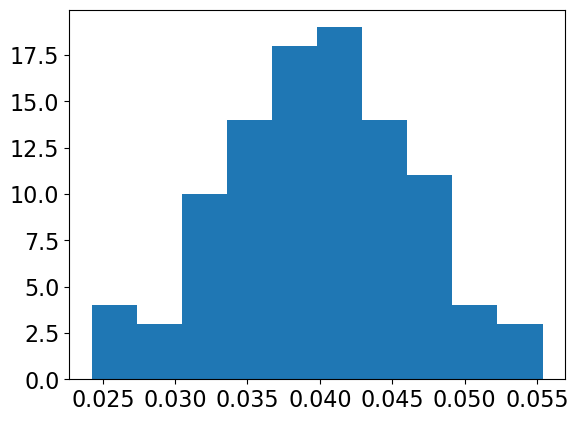

In [57]:
R_m3 , R_m4 , alpha_m3 , alpha_m4 , beta_m3 , beta_m4 , t_m3 , t_m4 , res_mm3 , res_mm4 = test()

In [58]:
T,R,M,Rerr, Merr,Terr = All['Teff'].to_numpy(),All['Radius'].to_numpy() ,All['Mass'].to_numpy() ,All['Rerr'].to_numpy() ,All['Merr'].to_numpy(),All['Terr'].to_numpy()
iteration = 100
alpha_m3 =np.zeros(iteration)
beta_m3 = np.zeros(iteration)
t_m3= np.zeros(iteration)
res_mm3 = np.zeros(iteration)
R_m3 = np.zeros(iteration)

alpha_m4 =np.zeros(iteration)
beta_m4 = np.zeros(iteration)
t_m4= np.zeros(iteration)
res_mm4 = np.zeros(iteration)
R_m4= np.zeros(iteration)

for pp in tqdm(range(iteration)):
    new_M = np.zeros(len(Merr))
    new_R = np.zeros(len(Rerr))
    for i, dM in enumerate(Merr):
        delM = stats.norm.rvs(loc=0,scale=dM)
        if (delM+ M[i])<= 0 :
            delM = 0.5* delM
        new_M[i] = M[i]+ delM
    for i, dR in enumerate(Rerr):
        delR = stats.norm.rvs(loc=0,scale=dR)
        if (delR+ R[i])<= 0 :
            delR = 0.5* delR        
        new_R[i] = R[i]+ delR
     

    log_M = np.log10(new_M)
    log_R = np.log10(new_R)
    x = np.row_stack((log_M,T))
    N = 50
    
    
    TT = np.logspace(-5,5,N)
    cc = np.linspace(0,1,N)
    a_all_Model3 = np.zeros(N)
    c_T_all_Model3 = np.zeros(N)
    b_M_all_Model3 = np.zeros(N)
    resM3 = np.zeros((N,N))
    beta3 = np.zeros(N)

    c_T_all_Model4 = np.zeros(N)
    b_M_all_Model4 = np.zeros(N)
    a_all_Model4 = np.zeros(N)
    resM4 = np.zeros((N,N))
    beta4 = np.zeros(N)


    for ii, t0 in tqdm(enumerate(TT)):
        def linfit_Model3(beta,x):
            return beta[0] + beta[1]*x[0] + beta[2]*np.log10(1+x[1]/t0)
        def linfit_Model4(beta,x):
            return beta[0] + beta[1]*x[0] + np.log10(1+(x[1]/t0)**beta[2])
        data = RealData(x,log_R)  
        linmod_Model3 = Model(linfit_Model3)
        linmod_Model4 = Model(linfit_Model4)  
        odr_model3 = ODR(data,linmod_Model3,beta0=[1.,1.,1.])
        odr_model4 = ODR(data,linmod_Model4,beta0=[1.,1.,1.])  
        out_model3=odr_model3.run()
        out_model4=odr_model4.run()
        a_all_Model3[ii],b_M_all_Model3[ii],c_T_all_Model3[ii] = out_model3.beta
        a_all_Model4[ii],b_M_all_Model4[ii],c_T_all_Model4[ii] = out_model4.beta
        for jj, beta in enumerate(cc):
            R_test_Model3 = np.log10(new_R/(1+T/t0)**(beta))
            R_test_Model4 = np.log10(new_R/(1+(T/t0)**(beta)))
            resM3[ii,jj] = np.std(R_test_Model3 -b_M_all_Model3[ii]*log_M)
            resM4[ii,jj] = np.std(R_test_Model4-b_M_all_Model4[ii]*log_M)
        mm3 = resM3[ii,:].argmin()
        beta3[ii] = cc[mm3]

        mm4 = resM4[ii,:].argmin()
        beta4[ii] = cc[mm4]

    tt_m3 = np.unravel_index(resM3.argmin(),resM3.shape)
    qq , beta0_m3 = tt_m3

    tt_m4 = np.unravel_index(resM4.argmin(),resM4.shape)
    kk , beta0_m4= tt_m4
    
    R_m3[pp] = a_all_Model3[qq]
    alpha_m3[pp] = b_M_all_Model3[qq]
    beta_m3[pp] = cc[beta0_m3] 
    t_m3[pp] = TT[qq]
    res_mm3[pp] = resM3[qq,beta0_m3]
    
    R_m4[pp] = a_all_Model4[kk]
    alpha_m4 [pp] = b_M_all_Model4[kk]
    beta_m4[pp] = cc[beta0_m4]
    t_m4[pp] = TT[kk]
    res_mm4[pp] = resM4[kk,beta0_m4]
    




  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]